## Run this notebook

You can launch this notbook using mybinder, by clicking the button below.

<a href="https://mybinder.org/v2/gh/nasa-veda-workshops/ieee-grss-webinar-2024/main?labpath=ieee-grss-webinar-mar-2024.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

   1. Fetch STAC items for the Terrestrial Water Storage (TWS) Anomaly `lis-tws-anomaly` dataset from the VEDA catalog.
   2. Visualize it in a map.
   3. Create a time-series chart of the collection for a datetime range and an area of interest.
   4. Compare items from 2017 vs 2021.
   5. Fetch STAC items for the Sentinel-2 Level 2A `sentinel-2-l2a` dataset from the Earth Search catalog (by Element84).
   7. Compare Normalized Difference Water Index (NDWI) visualization derived from Sentinel bands from 2017 vs 2021.
   8. Correlate the TWS comparison with the NDWI comparison to see the patterns.
   9. Create a new data product (NDWI) from the Sentinel data.
   10. Publish the new data product to the IEEE GRSS STAC catalog.
   11. Visualize it in the IEEE GRSS VEDA Dashboard.


In [5]:
pip install leafmap rio_stac --quiet

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import json
import requests
from datetime import datetime

import boto3
import getpass

import leafmap
from folium import TileLayer
import folium.plugins

import dask.array as da
import dask.distributed

from rio_stac import stac
from pystac_client import Client

import rasterio
import rioxarray as rxr
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

# TWS anomaly visualization and Analysis

Learn about the TWS Anomaly in [the VEDA dashboard](https://www.earthdata.nasa.gov/dashboard/data-catalog/tws-anomaly).

The TWS anomaly data resides in the VEDA catalog. We declare the VEDA API endpoints and the collection id.

In [7]:
# VEDA STAC and TiTiler endpoints
STAC_API_URL = "https://staging-stac.delta-backend.com"
RASTER_API_URL = "https://staging-raster.delta-backend.com"

# Collection id for tws anomaly dataset
collection_name = "lis-tws-anomaly"

### Fetch STAC collection
We will use `pystac.Client` to fetch all the metadata about the collection from STAC.

In [8]:
# Fetch collection from STAC catalog
api = Client.open(STAC_API_URL)
collection = api.get_collection(collection_name)
collection

<CollectionClient id=lis-tws-anomaly>

### Search the catalog for items within a datetime range

In [10]:
# Set temporal range to query
start_date = '2021-01-01'
end_date = '2021-12-01'

In [20]:
# Get items
items = api.search(
    datetime = f"{start_date}/{end_date}",
    collections = [collection.id]
)

print(f" Total number of assets in collection: {items.matched()}")

# Extract first item for exploration
items = items.item_collection_as_dict()["features"]
item = items[0]

 Total number of assets in collection: 335


### Visualize an item from the collection

In [12]:
# Extract visualization metadata for items
collection_dict = collection.to_dict()
viz_meta =collection_dict["renders"]["dashboard"]
viz_meta


{'bidx': [1],
 'title': 'VEDA Dashboard Render Parameters',
 'assets': ['cog_default'],
 'rescale': [[-200, 200]],
 'resampling': 'bilinear',
 'colormap_name': 'rdylbu'}

In [14]:
# Make request to TiTiler for tiles for the specific item using `/stac/tilejson.json` endpoint

tiles = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={item['collection']}&item={item['id']}"
    f"&assets={viz_meta['assets'][0]}"
    f"&colormap_name={viz_meta['colormap_name']}"
    f"&rescale={viz_meta['rescale'][0][0]},{viz_meta['rescale'][0][1]}",
).json()
tiles

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://staging-raster.delta-backend.com/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=lis-tws-anomaly&item=Anomaly_TWS_20211201.cog&assets=cog_default&colormap_name=rdylbu&rescale=-200%2C200'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-179.9500000157243,
  -59.98224871364589,
  179.9973980503783,
  89.9999999874719],
 'center': [0.023699017327004412, 15.008875636913004, 0]}

In [15]:
# Visualize first item in collection

# Declare the map
map = leafmap.Map(center=tiles["center"], zoom=2, draw_control=True, measure_control=False, 
                  fullscreen_control=False, attribution_control=True, tiles=tiles)

# Add geocoder to the map that lets us search location
geocoder_url = "https://nominatim.openstreetmap.org/search?format=json&q={s}"
map.add_search_control(geocoder_url)

# Add tiles to the map
map.add_tile_layer(tiles["tiles"][0], name=collection_dict["title"], attribution=collection_dict["providers"][0]["name"])

# Show the map
map

Map(center=[0.023699017327004412, 15.008875636913004, 0], controls=(AttributionControl(options=['position', 'p…

In [16]:
# Save the selected location as geojson
map.save_draw_features("bbox.geojson")

In [17]:
# Read the AOI
aoi = json.load(open("bbox.geojson", "r"))
aoi

{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-110.861664, 37.347431],
      [-110.861664, 37.533884],
      [-110.622711, 37.533884],
      [-110.622711, 37.347431],
      [-110.861664, 37.347431]]]}}]}

### Timeseries analysis

In [19]:
# Define method for calling statistics endpoint

def generate_stats(item, aoi):
    result = requests.post(f"{RASTER_API_URL}/cog/statistics",
                          params={"url": item["assets"]["cog_default"]["href"]},
                          json = aoi,
            ).json()
    return {
        **result["features"][0]["properties"],
        "start_datetime": item["properties"]["datetime"],
    }

In [21]:
# Generate time-series of statistics with dask

client = dask.distributed.Client()
futures = [client.submit(generate_stats, item, aoi) for item in items]
stats = client.gather(futures)

In [ ]:
stats

In [23]:
# Utility function that takes the API response and converts it into a pandas dataframe for easier use
def clean_stats(stats_json):
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["start_datetime"])
    return df


df = clean_stats(stats)

Text(0.5, 1.0, 'Provider: NASA VEDA')

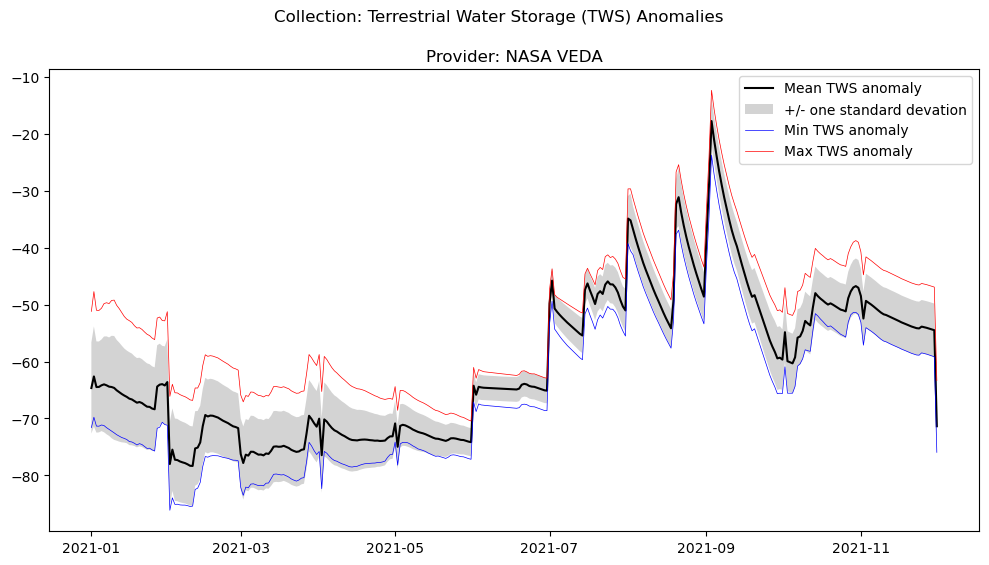

In [25]:
# Plot the time-series for the items

fig = plt.figure(figsize=(12,6))
plt.plot(df["date"], df["mean"], "black", label="Mean TWS anomaly")

plt.fill_between(
    df["date"],
    df["mean"] + df["std"],
    df["mean"] - df["std"],
    facecolor="lightgray",
    interpolate=False,
    label="+/- one standard devation",
)

plt.plot(
    df["date"],
    df["min"],
    color="blue",
    linestyle="-",
    linewidth=0.5,
    label="Min TWS anomaly",
)
plt.plot(
    df["date"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Max TWS anomaly",
)

plt.legend()
plt.suptitle(f"Collection: {collection_dict['title']}")
plt.title(f"Provider: {collection_dict['providers'][0]['name']}")


## Comparison with Sentinel-2 Data set from the Earth Search STAC catalog (AWS OpenData Registry)

Now let's bring in Sentinel-2 data from another STAC catalog to supplement the TWS anomaly dataset.

We can follow the exact same process to read this Collection. Since both of the catalogs are STAC catalogs, we can reuse the same methods to read them. Yay for interoperability!

In [26]:
# Define the STAC endpoint
s2_stac_endpoint = "https://earth-search.aws.element84.com/v1"

In [27]:
# Define the collection
s2_collection = "sentinel-2-l2a"

# Get collection
s2_api = Client.open(s2_stac_endpoint)
s2 = s2_api.get_collection(s2_collection)
s2

<CollectionClient id=sentinel-2-l2a>

### Now let's compare the trends of these two datasets

In [31]:
# Define a date range that we want for comparison

first_date_range = "2017-01-01/2017-12-15"
second_date_range = "2021-01-01/2021-01-15"

In [29]:
# Get one TWS anomaly item for each of these date range


# get tws for these two dates

# first date range
first_items = api.search(
    datetime = first_date_range,
    collections = [collection.id]  # collection refers to the tws collection
)
items = first_items.item_collection_as_dict()["features"]
# get the first item in this range
first_item = items[0]

# second date range
second_items = api.search(
    datetime = second_date_range,
    collections = [collection.id] # collection refers to the tws collection
)
items = second_items.item_collection_as_dict()["features"]
# get the first item in this range
second_item = items[0]

# Request tiles for these two items
first_tiles = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={item['collection']}&item={first_item['id']}"
    f"&assets={viz_meta['assets'][0]}"
    f"&colormap_name={viz_meta['colormap_name']}"
    f"&rescale={viz_meta['rescale'][0][0]},{viz_meta['rescale'][0][1]}",
).json()

second_tiles = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={item['collection']}&item={second_item['id']}"
    f"&assets={viz_meta['assets'][0]}"
    f"&colormap_name={viz_meta['colormap_name']}"
    f"&rescale={viz_meta['rescale'][0][0]},{viz_meta['rescale'][0][1]}",
).json()


# Show them in a map side by side
map_ = folium.plugins.DualMap(location=(36.9388454,-111.4950164), zoom_start=4)

first_tile_layer = TileLayer(
    tiles=first_tiles["tiles"][0],
    attr="VEDA",
    opacity=0.8,
    name="2017",
    overlay= True,
    legendEnabled = True
)

second_tile_layer = TileLayer(
    tiles=second_tiles["tiles"][0],
    attr="VEDA",
    opacity=0.8,
    name="2021",
    overlay= True,
    legendEnabled = True
)

first_tile_layer.add_to(map_.m1)
second_tile_layer.add_to(map_.m2)
folium.plugins.Geocoder().add_to(map_)
map_

In [32]:
# get sentinel for the same two date ranges

# only get items that have cloud_cover less than 5
query_params = {
    "eo:cloud_cover": {
        "lt": 5
    }
}

# Get the items
first_items = s2_api.search(
    datetime = first_date_range,
    collections = [s2_collection],
    query = query_params,
    intersects = aoi["features"][0]["geometry"],
)
items = first_items.item_collection_as_dict()["features"]
first_item = items[0]

second_items = s2_api.search(
    datetime = second_date_range,
    collections = [s2_collection],
    query = query_params,
    intersects = aoi["features"][0]["geometry"],
)
items = second_items.item_collection_as_dict()["features"]
second_item = items[0]

# Define the TiTiler URL to visualize the NDWI derived from these two items (shout-out to devseed!)
TITILER_URL = "https://titiler.xyz/"

# Define the query params
params = {
    "expression": "(green-nir)/(green+nir)", # the band expression for NDWI
    "asset_as_band": "true",
    "colormap_name": "viridis",
    "rescale": "-1,1"
}

# Request the tiles for the first item
params["url"] = f"{s2_stac_endpoint}/collections/{s2_collection}/items/{first_item['id']}"

first_tiles = requests.get(
    f"{TITILER_URL}/stac/tilejson.json",
    params=params,
).json()

# Request the tiles for the first item
params["url"] = f"{s2_stac_endpoint}/collections/{s2_collection}/items/{second_item['id']}"
second_tiles = requests.get(
    f"{TITILER_URL}/stac/tilejson.json",
    params=params
).json()

# Show them in a map
smap_ = folium.plugins.DualMap(location=(36.9388454, -111.4950164), zoom_start=4)
folium.plugins.Geocoder().add_to(smap_)

first_tile_layer = TileLayer(
    tiles=first_tiles["tiles"][0],
    attr="AWS OpenData Registry",
    opacity=0.8,
    name="2017",
    overlay= True,
    legendEnabled = True
)

second_tile_layer = TileLayer(
    tiles=second_tiles["tiles"][0],
    attr="AWS OpenData Registry",
    opacity=0.8,
    name="2021",
    overlay= True,
    legendEnabled = True
)

first_tile_layer.add_to(smap_.m1)
second_tile_layer.add_to(smap_.m2)

smap_

From Brian:
> Water storage is ground water. NDWI is surface water. They should be somewhat consistent so we’d expect to see a smaller amount of water detected with NDWI when there’s a negative water storage anomaly

# Creating and publishing a new data product

Using the sentinel-2 cog bands, we'll create a new data product for water mask using NDWI.

We'll need two bands for this. First is the `green` band and second is the `nir08` NIR band

In [39]:
# Define the two bands assets name in the catalog
green_band_asset_name = "green"
nir_band_asset_name = "nir"

In [40]:
# We'll use the first item from the search for the Sentine-2 data

# Extract the band tifs
green_url = first_item["assets"][green_band_asset_name]["href"]
nir_url = first_item["assets"][nir_band_asset_name]["href"]

In [41]:
# Free up some memory
import gc
gc.collect()

160

### Create the new product

In [48]:
# Open the COG files using rioxarray
green_data = rxr.open_rasterio(green_url, cache=False)
nir_data = rxr.open_rasterio(nir_url, cache=False)

# Apply the formula for NDWI
result = (green_data - nir_data) / (green_data + nir_data)

# Apply thresholding to get a water mask
threshold = 0.2
result_thresholded = (result > threshold).astype('uint8')

# Write the result to a new COG file
first_item_date_iso = first_item["properties"]["datetime"]
first_item_date = first_item_date_iso.split("T")[0]

out_file_name = f'watermask_{first_item_date}.tif'
result_thresholded.rio.to_raster(out_file_name, driver="COG", compress="DEFLATE", windowed=True, tiled=True)

### Publish the new data product to IEEE GRSS VEDA stac catalog

In [45]:
# Define the GRSS VEDA data store s3 bucket
bucket_name = "grss-veda-data-store"

# Define the collection id for the new dataset
collection_id = "watermask-from-sentinel-2"

### Upload files to the data store

In [46]:
s3_client = boto3.client('s3')

# Utility method for uploading the file to the bucket
def upload_files(files):
    uploaded_files = []
    for file in files:
        object_name = f"{collection_id}/{os.path.basename(file)}"
        s3_client.upload_file(file, bucket_name, object_name)
        uploaded_files.append(f"s3://{bucket_name}/{object_name}")
    return uploaded_files

In [47]:
# Upload the file
uploaded_files = upload_files(
    [out_file_name]
)
print(uploaded_files)

['s3://grss-veda-data-store/watermask-from-sentinel-2/watermask_2017-12-11.tif']


### Create a STAC collection

In [71]:
# The STAC collection spec can be found in this link: https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md

collection = {
  "id": collection_id,
  "type": "Collection",
  "links": [],
  "title": "Water mask created from sentinel-2 cogs",
  "assets": {},
  "extent": {
    "spatial": { "bbox": [first_item["bbox"]] },
    "temporal": {
      "interval": [[f"{first_item_date}T00:00:00+00:00", f"{first_item_date}T12:59:59+00:00"]]
    }
  },
  "license": "CC0-1.0",
  "description": "Water mask created from sentinel-2 cogs using the green and nir bands",
  "item_assets": {
    "cog_default": {
      "type": "image/tiff; application=geotiff; profile=cloud-optimized",
      "roles": ["data", "layer"],
      "title": "Default COG Layer",
      "description": "Cloud optimized default layer to display on map"
    }
  },
  "stac_version": "1.0.0",
  "stac_extensions": [],
  "dashboard:is_periodic": False,
  "dashboard:time_density": "day"
}
collection

{'id': 'watermask-from-sentinel-2',
 'type': 'Collection',
 'links': [],
 'title': 'Water mask created from sentinel-2 cogs',
 'assets': {},
 'extent': {'spatial': {'bbox': [[-111.0002151833884,
     36.951488600423914,
     -109.75065723902863,
     37.9475322078219]]},
  'temporal': {'interval': [['2017-12-11T00:00:00+00:00',
     '2017-12-11T12:59:59+00:00']]}},
 'license': 'CC0-1.0',
 'description': 'Water mask created from sentinel-2 cogs using the green and nir bands',
 'item_assets': {'cog_default': {'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'title': 'Default COG Layer',
   'description': 'Cloud optimized default layer to display on map'}},
 'stac_version': '1.0.0',
 'stac_extensions': [],
 'dashboard:is_periodic': False,
 'dashboard:time_density': 'day'}

### Get authorization to publish

In [51]:
## Get authorization to publish the dataset to the catalog

# Pull username and password from environment variables
username = "slesa"
password = getpass.getpass()

# Publication API URL
base_url = "https://daanwlof76.execute-api.us-west-2.amazonaws.com/dev"

# endpoint to get the token from
token_url = f"{base_url}/token"

# authentication credentials to be passed to the token_url
body = {
    "username": username,
    "password": password,
}

# request token
response = requests.post(token_url, data=body)
if not response.ok:
    raise Exception("Couldn't obtain the token. Make sure the username and password are correct.")
else:
    # get token from response
    token = response.json().get("AccessToken")
    # prepare headers for requests
    headers = {
        "Authorization": f"Bearer {token}"
    }

 ········


### Publish the collection

In [72]:
collection_url = f"{base_url}/collections"
response = requests.post(
    collection_url,
    headers=headers,
    json=collection
)

if response.ok:
    print("Success")

Success


In [55]:
response.json()

['Successfully published: watermask-from-sentinel-2']

Yay! The collection is published. We can go look at it in the catalog.

Catalog URL: [https://2311pup4hj.execute-api.us-west-2.amazonaws.com](https://2311pup4hj.execute-api.us-west-2.amazonaws.com)

### Create the STAC item

In [ ]:
id = uploaded_files[0].split(".")[0]

item = stac.create_stac_item(
    id=id,
    source=uploaded_files[0],
    collection=collection_id,
    input_datetime=datetime.fromisoformat(first_item_date_iso),
    properties={},
    with_proj=True,
    with_raster=True,
    asset_name="cog_default",
    asset_roles=["data", "layer"],
    asset_media_type="image/tiff; application=geotiff; profile=cloud-optimized",
)

print(item.to_dict())


### Publish the STAC item

In [74]:
# url for dataset validation / publication
ingestion_url = f"{base_url}/ingestions"

# Validate the data definition using the /validate endpoint
response = requests.post(
    ingestion_url,
    headers=headers,
    json=item.to_dict()
)

if response.ok:
    print("Success")

Success


The item should now be available in the catalog!

# IEEE GRSS VEDA links

- Dashboard: [http://veda-config-ieee.s3-website-us-west-2.amazonaws.com/](http://veda-config-ieee.s3-website-us-west-2.amazonaws.com/)
- STAC API: [https://2311pup4hj.execute-api.us-west-2.amazonaws.com/docs](https://2311pup4hj.execute-api.us-west-2.amazonaws.com/docs)
- TiTiler API: [https://ducbzwnzhb.execute-api.us-west-2.amazonaws.com/docs](https://ducbzwnzhb.execute-api.us-west-2.amazonaws.com/docs)
- Ingestion API: [https://daanwlof76.execute-api.us-west-2.amazonaws.com/dev/docs](https://daanwlof76.execute-api.us-west-2.amazonaws.com/dev/docs)